In [2]:
import xarray as xr
import numpy as np
import tools
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
from datetime import datetime 
from datetime import timedelta

import scipy.interpolate as interp

scrip.so not found. Remapping function will not be available


# Assessment of the OSSE simulations

An assesment of the OSSE simulations will be done here. We will try to perform it in a analogue way to the one done for the OSE, where real observations were used for assimilation and assesment.

- SLA: The value of the NR at the position of the regular satellite tracks will be extracted and compared to the simulations.
    
- SST: The NR surface temperature field will be considered and subsampled, reducing the resolution to 10 km by picking one of every four observations both in vertical and horizontal.
    
- ARGO: Temperature and salinity profiles at position of the buoys during the experiment will be extracted from NR and simulations and compared
    
- TS profiles will algo be assesed in areas of the domain distant from assimialt4ed observations. This way, the capabilities of the model will also be assesed.

- HFR: The data samples taken apart for validation will be used for this purpose

## SST

### Calcualte RMSD

For each of the different experiments the RMSD is calculated for every day of simulation, interpolating the SLA field to the postion of the observations. The positions will be considered the same all along the experiment

In [3]:
available_zones = {
 'WesternMed':[[-5.8, 9.2, 34.9, 44.55],6,0.3],
 'AlboranSea':[[-5.8, 0, 34.9, 37.8],3,0.1],
 'BalearicIslands':[[-1, 5.5, 37.8, 41.5],4,0.2],
 'BalearicIslands2':[[1, 5, 38, 40],4,0.2],
 'PRESWOT':[[1.81,4.68,38.13,39.57],2,0.2],
 'MallorcaMenorca':[[2, 4.5, 38.8, 40.5],3,0.15],
 'IbizaFormentera':[[0.7, 2, 38.4, 39.5],2,0.1],
 'IbizaChannel':[[-0.2, 2, 38.1, 39.5],3,0.13],
 'MallorcaChannel':[[1.4, 3.6, 38.6, 40.1],3,0.13],
 'EastAlgerian':[[2.9, 9.2, 36.2, 39.5],2,0.2],
 'GulfLion':[[2.2, 6 ,41.5, 43.8],3,0.1],
 'REP14-MED':[[6.5, 8.7, 38.5, 41],1,0.1],
 'Ligurian':[[4, 9.2, 41, 44.55],2,0.2],
 'SardiniaChannel':[[8, 9.2, 36.8, 39.2],2,0.2]
 }

In [53]:
import scipy.interpolate as interp
import skill_metrics as sm

# Define initial and end date
date = datetime(2014,9,21)
date_end = datetime(2014,10,19)

# Experiment names from which to extract equivalents to observations and to calculate RMSD
exp_names = ['NOASSIM', 'generic_nudging', 'all_future_nudging', 'all_actual_nudging', 'generic_nonudging', 'all_future_nonudging', 'all_actual_nonudging']
# number of days of simulation
ndays = (date_end - date).days

# Initialize empty dictionary and arrays
rmsd = {}
sst_obs_total = {}  # array containing all observations (concatenate each day obs)
sst_wmop_total = {}  # array containing all wmop obs
for exp in exp_names:
    rmsd[exp] = {}
    sst_obs_total[exp] = {}
    sst_wmop_total[exp] = {}
    
    for zone in available_zones:        
        rmsd[exp][zone] = np.empty(ndays)
        sst_obs_total[exp][zone] = np.array([])
        sst_wmop_total[exp][zone] = np.array([])

# Loop over days
for i in range(ndays):
    
    strdate = date.strftime('%Y%m%d')    

    # Loop over different simulations
    for exp in exp_names: 

        if exp in ['NOASSIM']:
            path_wmop = path_wmop = '/home/modelling/data/workdir_2/HFR_DA/HFR_{0}_Oct2014'.format(exp)
        else:
            path_wmop = '/DATA/jhernandez/ROMS/Outputs/HFR_{0}_Oct2014_OSSE/'.format(exp)
            
        file_wmop = '{0}/roms_WMOP_ASSIM_{1}_avg.nc'.format(path_wmop, strdate)
        file_nr = '/home/modelling/data/WMOP/WMOP_FORECAST/Outputs/FORECAST_CMEMS_RESTARTS/forecast_scratch//roms_WMOP_FORECAST_{0}_his.nc'.format(strdate)

        ds_wmop = xr.open_dataset(file_wmop)
        ds_nr = xr.open_dataset(file_nr)

        # Get SST values for WMOP and Observations (NR)
        nb=4 # subsampling
        sst1 = ds_wmop.temp[0,-1,1:-1:nb,1:-1:nb].values.reshape(-1)
        sst2 = ds_nr.temp[3,-1,1:-1:nb,1:-1:nb].values.reshape(-1) 
                
        lon = ds_wmop.lon_rho[1:-1:nb,1:-1:nb].values.reshape(-1)
        lon = lon[np.isnan(sst2)==0]
        lat = ds_wmop.lat_rho[1:-1:nb,1:-1:nb].values.reshape(-1)
        lat = lat[np.isnan(sst2)==0]
        
        sst1 = sst1[np.isnan(sst1)==0]
        sst2 = sst2[np.isnan(sst2)==0]
        
        for zone in available_zones:
            
            limits = available_zones[zone][0]
            idx = ( (lon>limits[0]) & (lon<limits[1])  & (lat>limits[2]) & (lat<limits[3]) )
                        
            # Compute RMSD
            rmsd[exp][zone][i] = sm.rmsd(sst2[idx], sst1[idx])

            sst_obs_total[exp][zone] = np.concatenate((sst_obs_total[exp][zone], sst2[idx]))
            sst_wmop_total[exp][zone] = np.concatenate((sst_wmop_total[exp][zone], sst1[idx]))

    date = date + timedelta(days=1)
        
print('DONE')

DONE


In [43]:
rmsd

{'NOASSIM': {'WesternMed': array([0.62672397, 0.65508524, 0.71415951, 0.74702807, 0.75912885,
         0.7973711 , 0.83127822, 0.82180125, 0.78201101, 0.75964937,
         0.80358975, 0.81613033, 0.81590506, 0.80685194, 0.76325841,
         0.7787155 , 0.7637645 , 0.73700268, 0.71468683, 0.70082508,
         0.67365331, 0.67100343, 0.69174056, 0.69552004, 0.72297975,
         0.7377565 , 0.71162086, 0.67602279]),
  'AlboranSea': array([0.92525143, 0.97110124, 1.12962548, 1.11209922, 1.13703207,
         1.14898515, 1.14320603, 1.16508597, 1.01383905, 0.96478337,
         1.12077214, 1.04235367, 0.95972414, 0.89616049, 0.85072128,
         0.83968407, 1.10330124, 1.0618359 , 1.01686576, 1.0114298 ,
         0.96732286, 0.89717718, 0.95806931, 0.99922317, 1.05265942,
         1.07208081, 1.01057551, 0.86644525]),
  'BalearicIslands': array([0.59088348, 0.62840462, 0.67193813, 0.74025238, 0.73949651,
         0.82254582, 0.88839222, 0.85881656, 0.82527934, 0.84491137,
         0.86785027,

## Plot RMSD evolution (by area)

In [46]:
t0 = datetime(2014,9,21)
t = [t0 + timedelta(days=i) for i in range(31)]
xt = range(0,31,3)
tt = [time.strftime('%d/%m/%Y') for time in t]

In [14]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

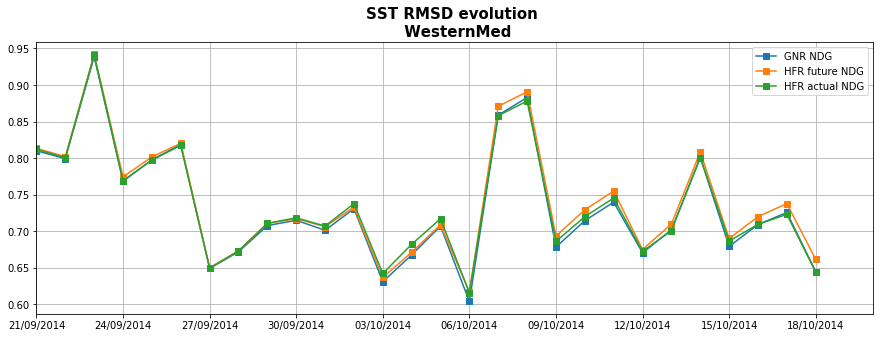

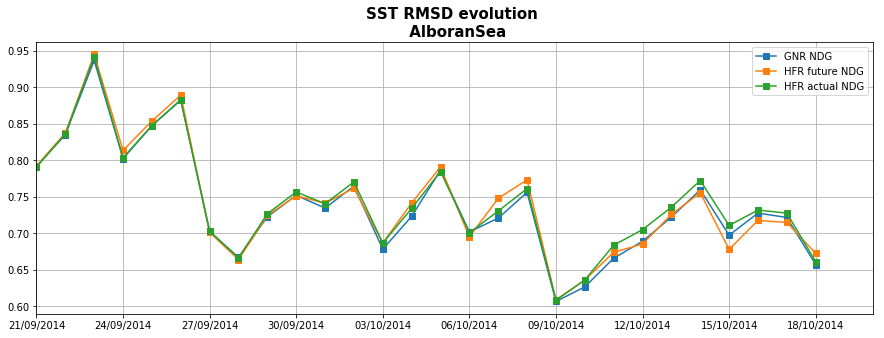

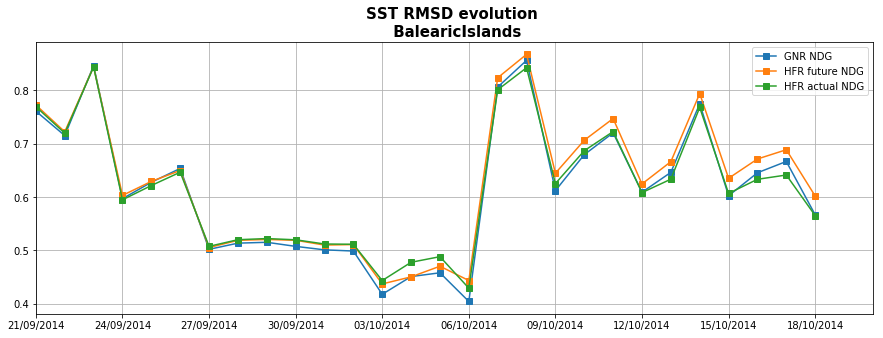

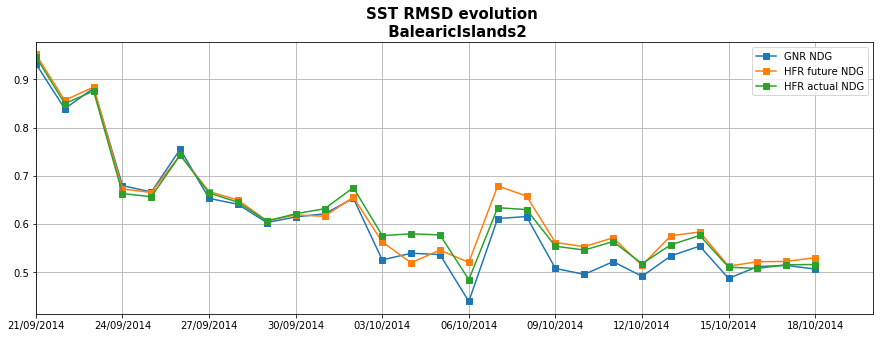

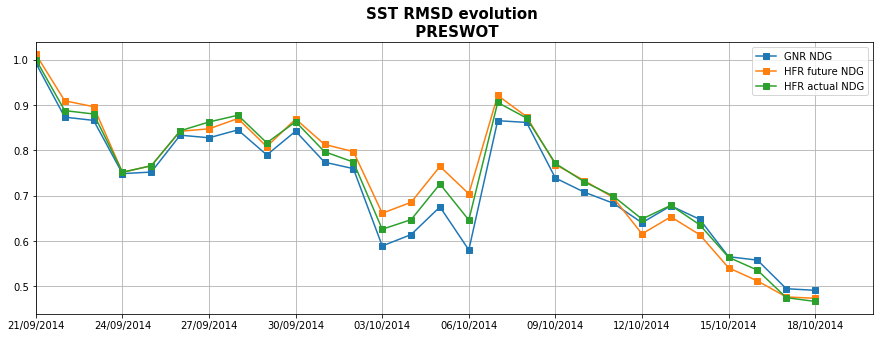

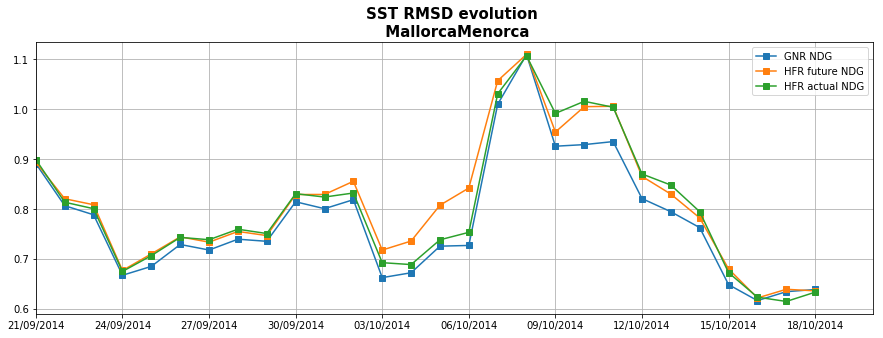

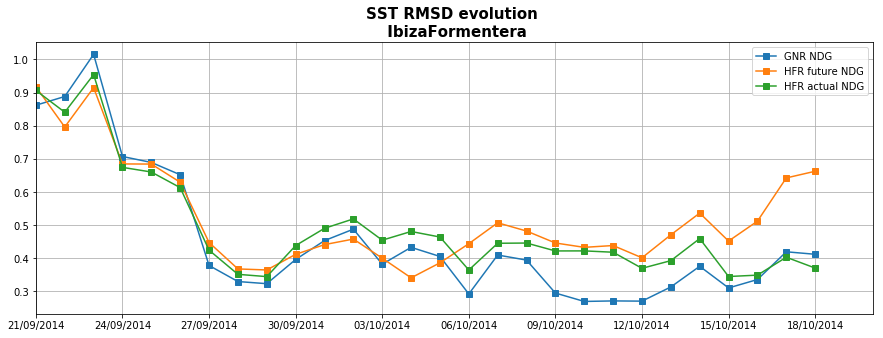

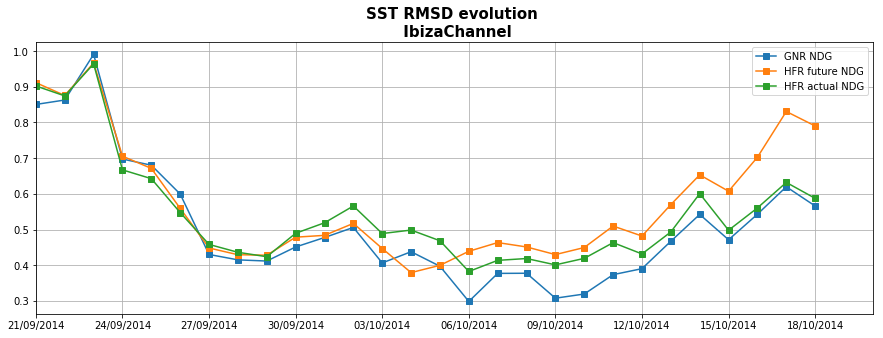

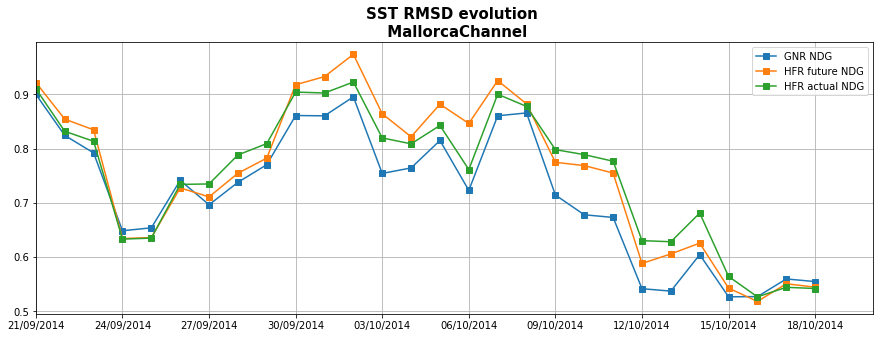

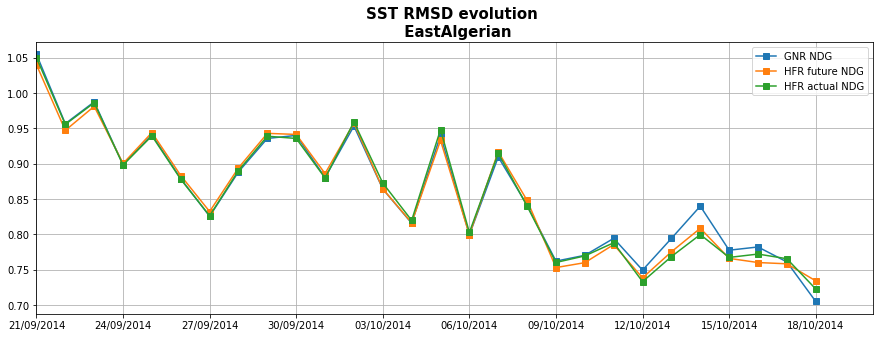

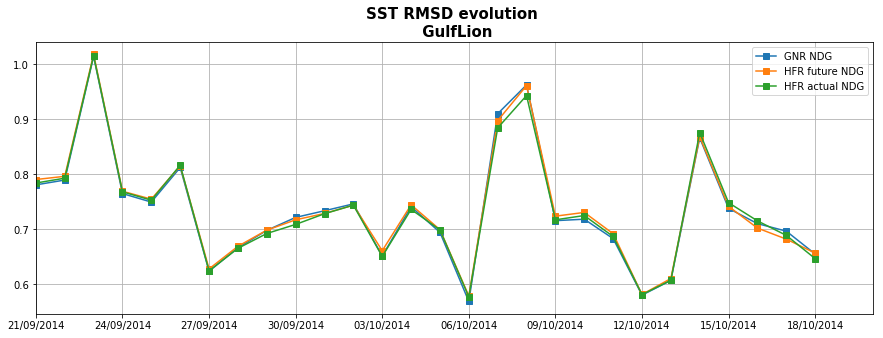

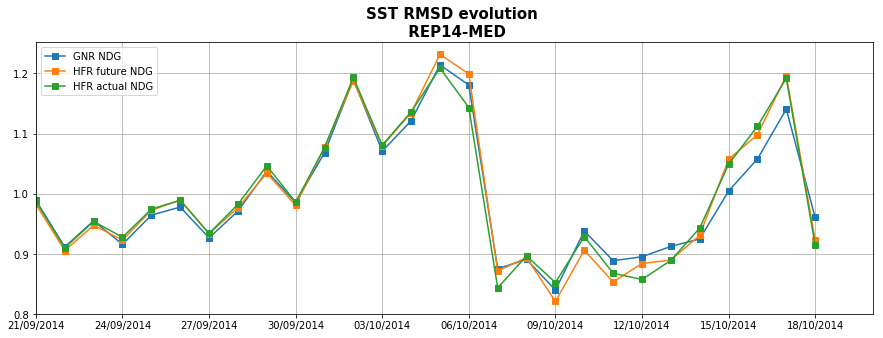

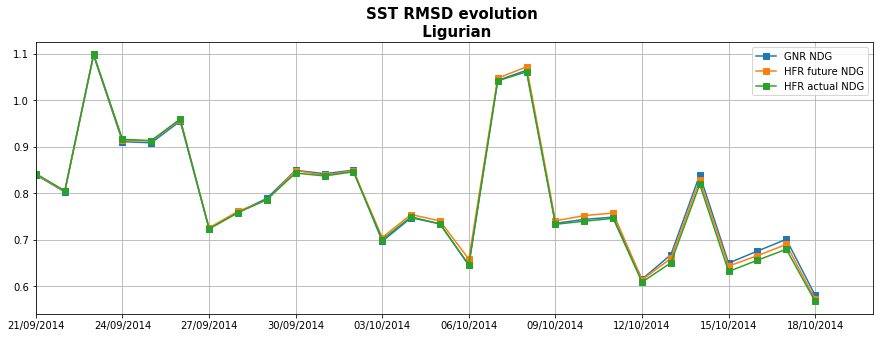

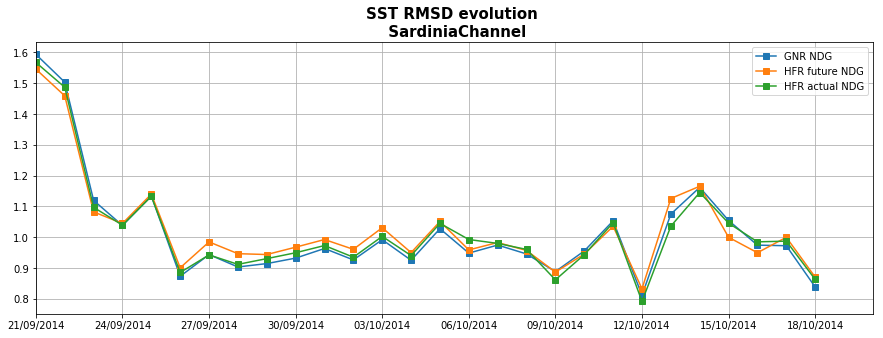

In [59]:
# Define experiments and labels for legend
exp_names = ['NOASSIM', 'generic_nudging', 'generic_nonudging', 'all_future_nudging', 'all_future_nonudging', 'all_actual_nudging', 'all_actual_nonudging']
labels = ['NOASSIM', 'GNR NDG', 'GNR ANL', 'HFR future NDG', 'HFR future ANL', 'HFR actual NDG', 'HFR actual ANL']
colors = ['black', 'olivedrab', 'darkgreen', 'dodgerblue', 'darkblue', 'salmon', 'darkred']

# Subset
subset = [1,3,5]
#subset = [2,4,6]
exp_names = [exp_names[i] for i in subset];  labels = [labels[i] for i in subset]; colors = [colors[i] for i in subset]


for zone in available_zones:
    fig = plt.figure(figsize=(15,5))

    for exp in exp_names:

        plt.plot(rmsd[exp][zone] / rmsd['NOASSIM'][zone], marker='s', linestyle='-')
    plt.legend(labels)
    plt.xticks(ticks=list(xt),labels=tt[0:-1:3])
    plt.grid(True)
    plt.title('SST RMSD evolution \n {0}'.format(zone), fontsize=15, fontweight='bold')
    plt.xlim((0,29))
    plt.show()

In [16]:
fig.savefig('/home/jhernandez/Escritorio/OSSE/rmsd_evolution_SST_OSSE.png', dpi=250)

In [17]:
for exp in exp_names[1:]:
    
    print(np.mean(rmsd[exp], axis=0)/ np.mean(rmsd['NOASSIM'], axis=0))

0.7382205618900785
0.7347450732160143
0.7313895464609431


## Taylor Diagram

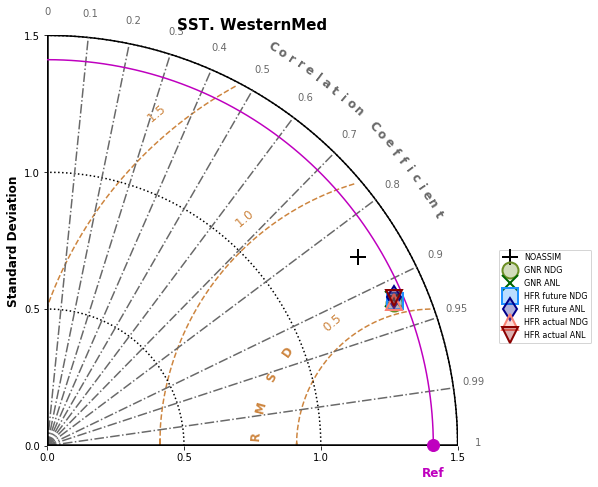

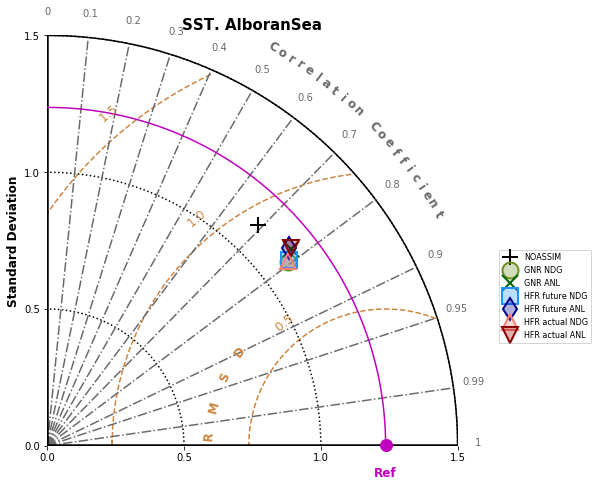

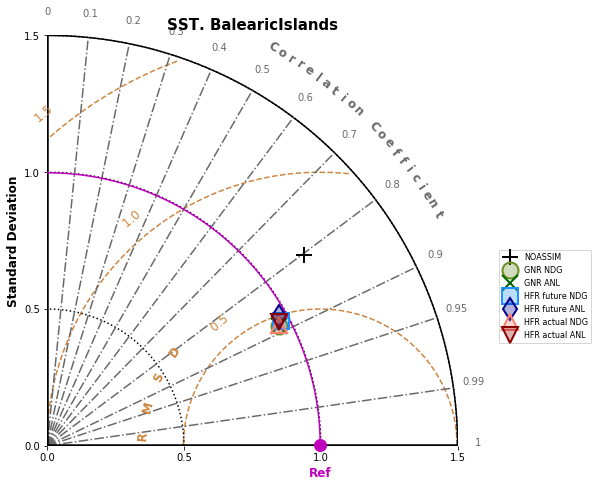

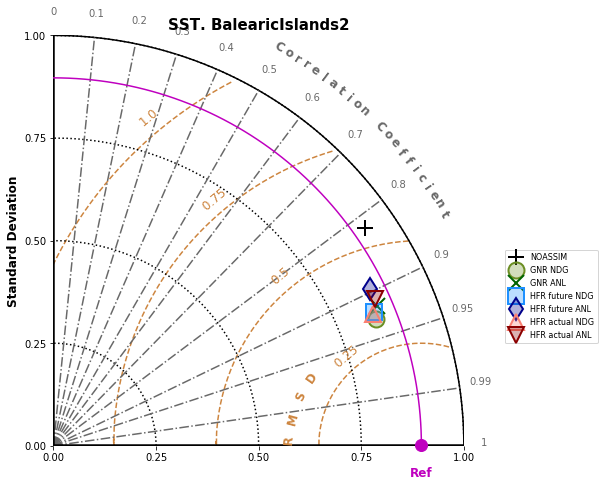

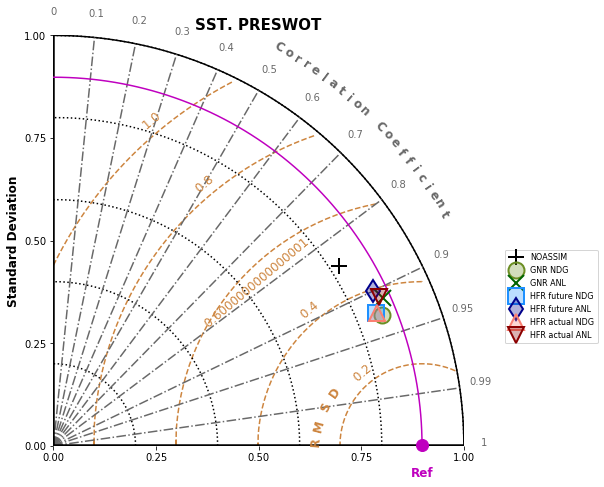

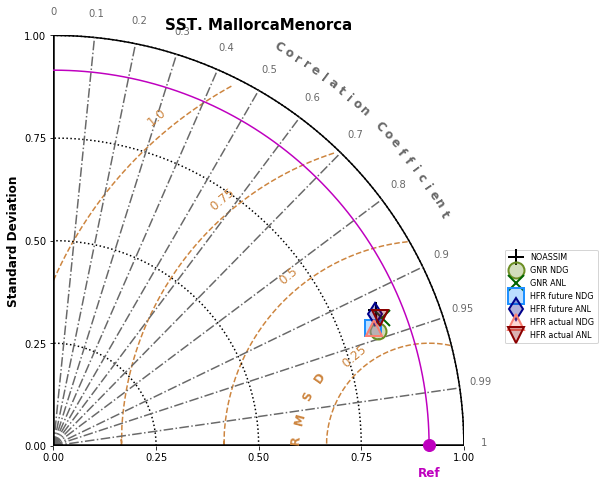

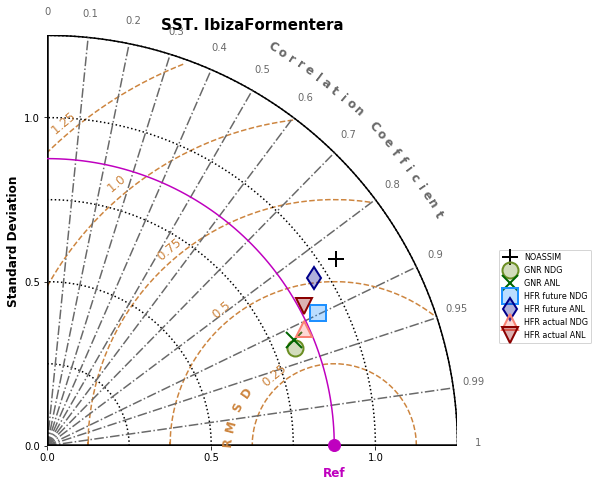

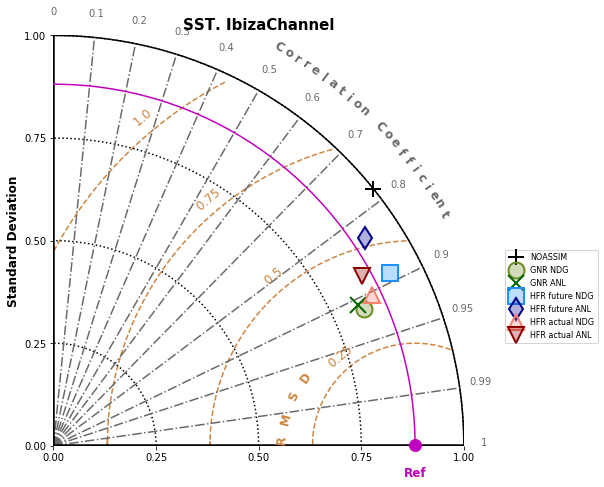

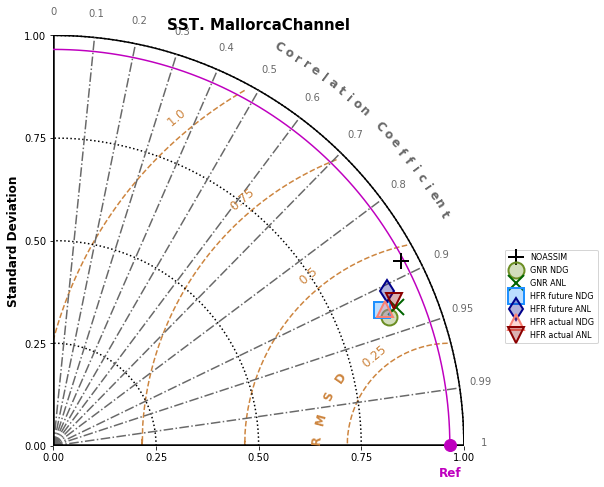

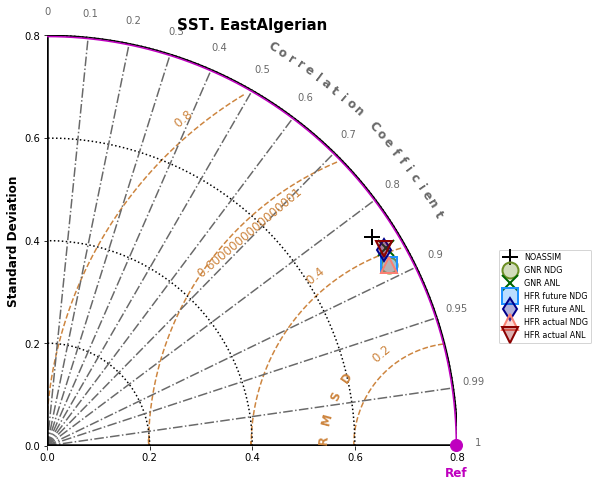

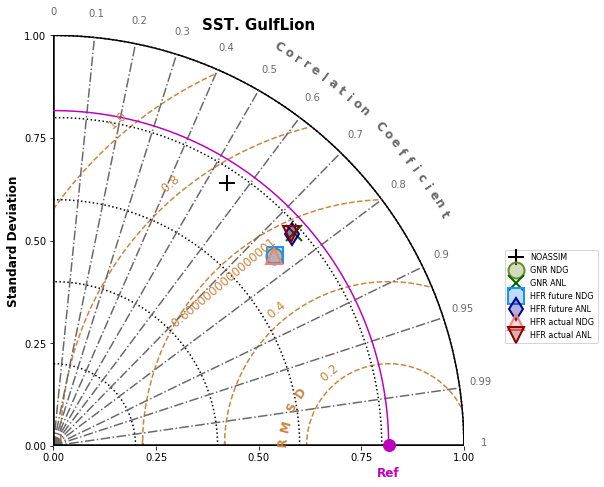

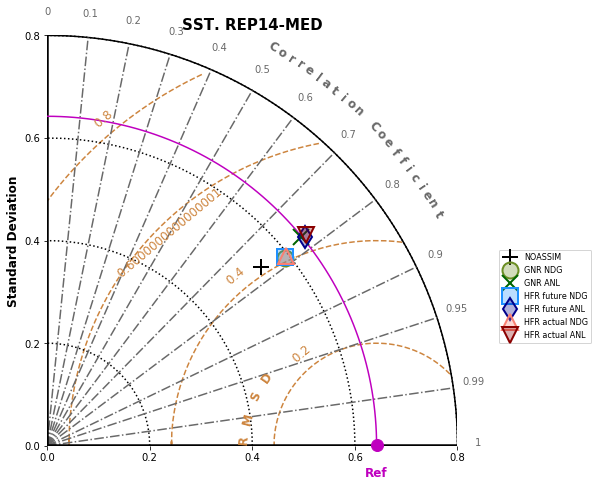

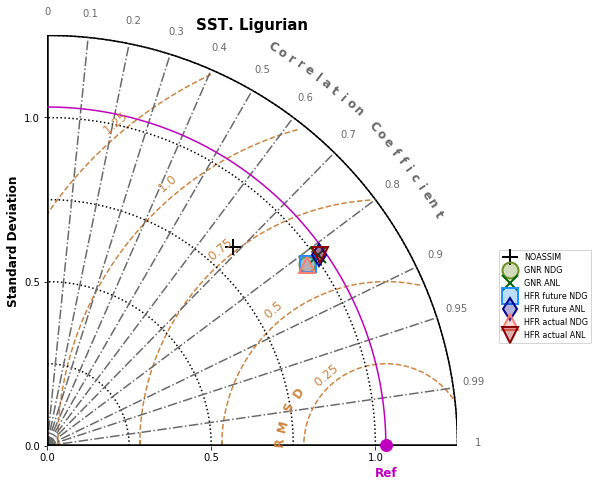

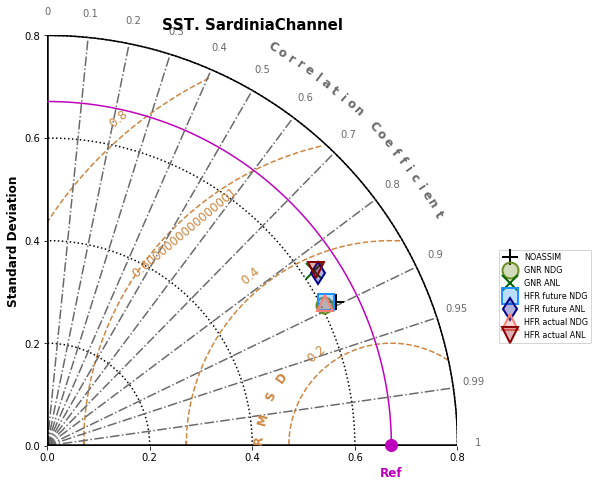

In [58]:
# Define experiments and labels for legend
exp_names = ['NOASSIM', 'generic_nudging', 'generic_nonudging', 'all_future_nudging', 'all_future_nonudging', 'all_actual_nudging', 'all_actual_nonudging']
labels = ['NOASSIM', 'GNR NDG', 'GNR ANL', 'HFR future NDG', 'HFR future ANL', 'HFR actual NDG', 'HFR actual ANL']
colors = ['black', 'olivedrab', 'darkgreen', 'dodgerblue', 'darkblue', 'salmon', 'darkred']

# Subset
subset = [1,3,5]
subset = [2,4,6]
#exp_names = [exp_names[i] for i in subset];  labels = [labels[i] for i in subset]; colors = [colors[i] for i in subset]

label = ['SST'] + labels

for zone in available_zones:
    
    sdev = []; crmsd = []; ccoef = []; taylor_stats = {}

    # Calculate taylor diagram stats for the different experiments selcted
    for e in exp_names:
        taylor_stats[e] = sm.taylor_statistics(sst_wmop_total[e][zone], sst_obs_total[e][zone])
        sdev.append(taylor_stats[e]['sdev'][1])
        crmsd.append(taylor_stats[e]['crmsd'][1])
        ccoef.append(taylor_stats[e]['ccoef'][1])

    # Add reference value and convert to array
    sdev = np.array([taylor_stats['NOASSIM']['sdev'][0]] + sdev)
    crmsd = np.array([taylor_stats['NOASSIM']['crmsd'][0]] + crmsd)
    ccoef = np.array([taylor_stats['NOASSIM']['ccoef'][0]] + ccoef)
    

    fig_taylor_sst = plt.figure(num=1, figsize=(12,8))
    sm.taylor_diagram(sdev,crmsd,ccoef, markerLabel=label,  markerLabelColor = 'r', markerDisplayed = 'marker',
                          markerLegend = 'on', markercolor = colors,
                          styleOBS = '-', colOBS = 'm', markerobs = 'o',
                          markerSize = 16,  
                          colRMS = 'peru', colCOR = 'dimgrey',
                          tickRMSangle = 130, showlabelsRMS = 'on',
                          titleRMS = 'on', titleOBS = 'Ref', checkstats = 'on', alpha=0.3)#, overlay=True)

    plt.title('SST. {0}'.format(zone), fontsize=15, fontweight='bold')
    plt.show()

In [19]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)

In [21]:
fig_taylor_sst.savefig('/home/jhernandez/Escritorio/OSSE/taylor_diagram_SST_OSSE.png', dpi=250)